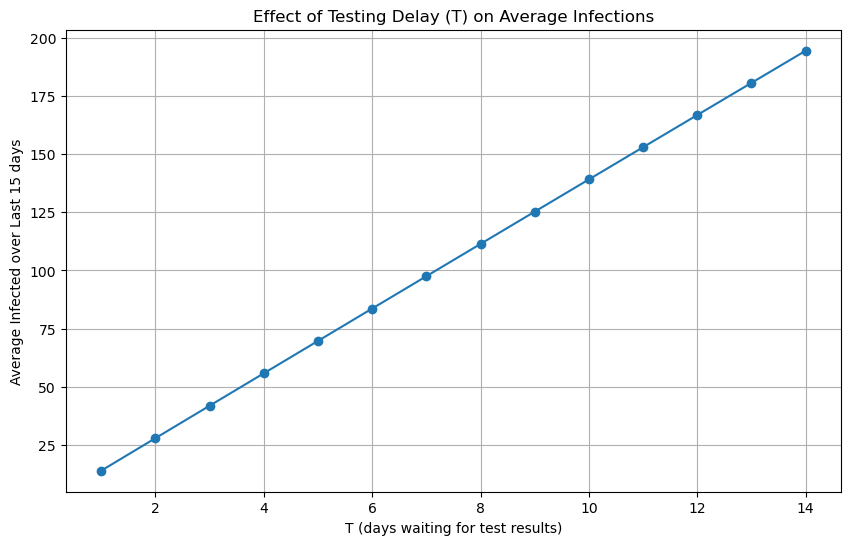

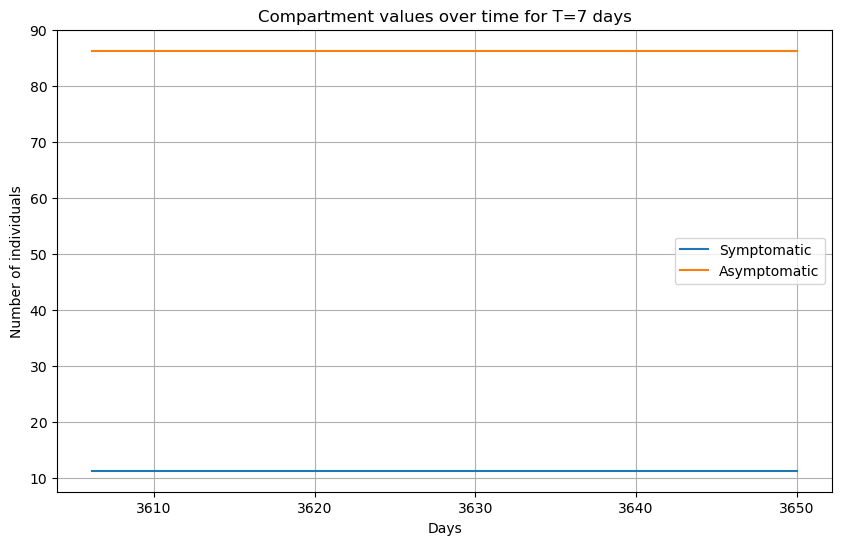

In [19]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Model Parameters

#Transmission probability
prob=0.5

# Transmission rate.
beta = prob*(1.5/7) #prob of infection, 1 partners per week, so roughly 1/7th of pop infected per day? 

# Transition rate from exposed to infectious.
epsilon = 1/5

# Recovery rate for individuals post-treatment.
gamma_s = 1/7  

# Probability of asymptomatic infection upon exposure.
lambda_ = 0.8

# Natural spontaneous clearance rate of the infection.
gamma_clear =1/14  #about two weeks recovery time 


# Total population.
N = 100000

# Testing rate for Group A (20% of population tested every 3 months)
# 30.5 is the approximate number of days in three months 
daily_tests_A = 0.2 * N / (3 * 30.5)

# Testing rate for Group B (80% of population tested every year)
# 30.5 is the approximate number of days in three months.
daily_tests_B = 0.8 * N / (12 * 30.5)




#Remark: in the paper, daily_tests is called tau and positive_asymptomatic_tests is simplified to tau*A/N

# Initial conditions
E0 = 0.5*N # Initial exposed individuals.
X0 = N - E0  # Initial susceptible individuals.
S0 = 0        # Initial symptomatic individuals.
A0 = 0        # Initial asymptomatic individuals.

# Time vector for simulation.
t = np.linspace(0, 10*365, 1000)

# Model Definition

def gonorrhea_model(y, t, beta, epsilon, gamma_s, lambda_, T, N):
    X, E, S, A = y

    # For group A
    detection_rate_A = (daily_tests_A * A) / N
    # For group B
    detection_rate_B = (daily_tests_B * A) / N
    
    # Total detection rate
    total_detection_rate = detection_rate_A + detection_rate_B
    
   
    # Rate for natural spontaneous clearance for asymptomatic individuals.
    gamma_a_clear = 0.60 * gamma_clear  #only for 60% of individuals 
    
     # Effective recovery rate for symptomatic individuals due to treatment.
    # This assumes that syptomatic individuals are tested and treated immediately, which 
    # I believe is inline with current protocol
    gamma_s_eff = gamma_s + gamma_a_clear 
    
    
    # Effective recovery rate for asymptomatic individuals.
    # Asymptomatic individuals clear either due to testing/treatment 
    # or due to natural spontaneous clearance.
    # Note that, asymptotically as T goes to infinity, there is essentially no testing/treatment
    gamma_a_eff =total_detection_rate/T + gamma_a_clear #units = recoveries / day
    
    
    # Dynamics for susceptible compartment.
    # New infections occur through contact with symptomatic/asymptomatic individuals.
    # Recovery from symptomatic and asymptomatic states replenishes the susceptibles.
    #
    dXdt = -beta * X * (S + A) / N + gamma_s_eff * S + gamma_a_eff * A  
    
    # Dynamics for exposed compartment.
    # Individuals move from exposed to either symptomatic or asymptomatic state.
    dEdt = beta * X * (S + A) / N - epsilon * E  
    
    # Dynamics for symptomatic compartment.
    # Symptomatic individuals recover with an effective rate gamma_s_eff.
    dSdt = (1 - lambda_) * epsilon * E - gamma_s_eff * S  
    
    # Dynamics for asymptomatic compartment.
    # Asymptomatic individuals recover with an effective rate gamma_a_eff.
    dAdt = lambda_ * epsilon * E - gamma_a_eff * A  
    
    return [dXdt, dEdt, dSdt, dAdt]
# Simulation & Visualization for varying T values.

Ts = list(range(1, 15))
average_infected = []

for T in Ts:
    solution = odeint(gonorrhea_model, [X0, E0, S0, A0], t, args=(beta, epsilon, gamma_s, lambda_, T, N))
    avg_infected_last_15_days = np.mean(solution[-15:, 2] + solution[-15:, 3])
    average_infected.append(avg_infected_last_15_days)

# Plot average infections for varying T values.
plt.figure(figsize=(10, 6))
plt.plot(Ts, average_infected, marker='o')
plt.xlabel('T (days waiting for test results)')
plt.ylabel('Average Infected over Last 15 days')
plt.title('Effect of Testing Delay (T) on Average Infections')
plt.grid(True)
plt.show()

# Plot compartment values over time for a specific T value (e.g., T=7).
T_specific = 7
solution_T_specific = odeint(gonorrhea_model, [X0, E0, S0, A0], t, args=(beta, epsilon, gamma_s, lambda_, T_specific, N))

# Number of points to display for the last n days
n=50
last_n_days_points = int(n * (1000 / (10 * 365)))

# Adjust the time array and solution array for the specific T value.
t_last_n = t[-last_n_days_points:]
solution_T_specific_last_n = solution_T_specific[-last_n_days_points:]

plt.figure(figsize=(10, 6))
#plt.plot(t_last_n, solution_T_specific_last_n[:, 0], label="Susceptible")
#plt.plot(t_last_n, solution_T_specific_last_n[:, 1], label="Exposed")
plt.plot(t_last_n, solution_T_specific_last_n[:, 2], label="Symptomatic")
plt.plot(t_last_n, solution_T_specific_last_n[:, 3], label="Asymptomatic")
plt.xlabel('Days')
plt.ylabel('Number of individuals')
plt.title(f'Compartment values over time for T={T_specific} days')
plt.legend()
plt.grid(True)
plt.show()


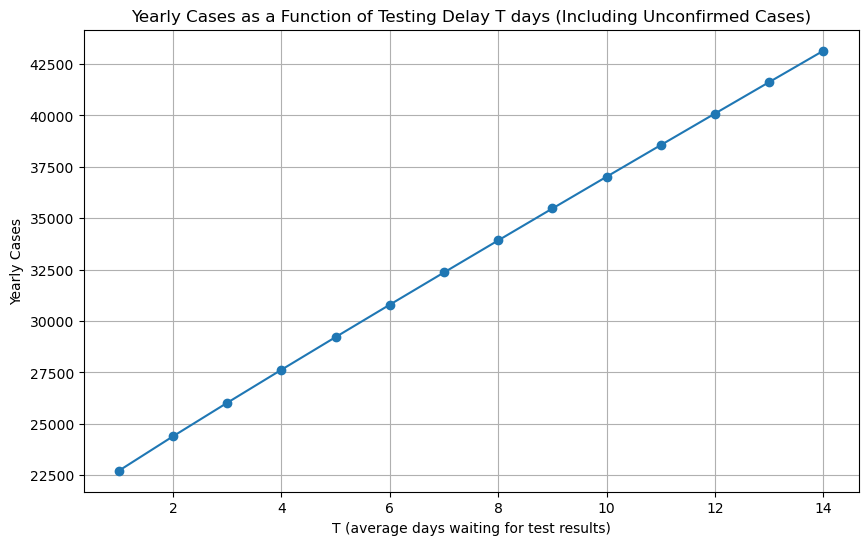

In [20]:


# New list to store yearly cases for each T value
yearly_cases = []

for T in Ts:
    solution = odeint(gonorrhea_model, [X0, E0, S0, A0], t, args=(beta, epsilon, gamma_s, lambda_, T, N))
    
    # Calculate the flow into symptomatic and asymptomatic compartments for each time step
    symptomatic_flow = (1 - lambda_) * epsilon * solution[:, 1]
    asymptomatic_flow = lambda_ * epsilon * solution[:, 1]
    
    # Sum the flow over one year (or the entire duration in this case)
    total_cases_for_T = np.sum(symptomatic_flow + asymptomatic_flow)
    
    yearly_cases.append(total_cases_for_T)

# Plot yearly cases for varying T values
plt.figure(figsize=(10, 6))
plt.plot(Ts, yearly_cases, marker='o')
plt.xlabel('T (average days waiting for test results)')
plt.ylabel('Yearly Cases')
plt.title('Yearly Cases as a Function of Testing Delay T days (Including Unconfirmed Cases)')
plt.grid(True)
plt.show()

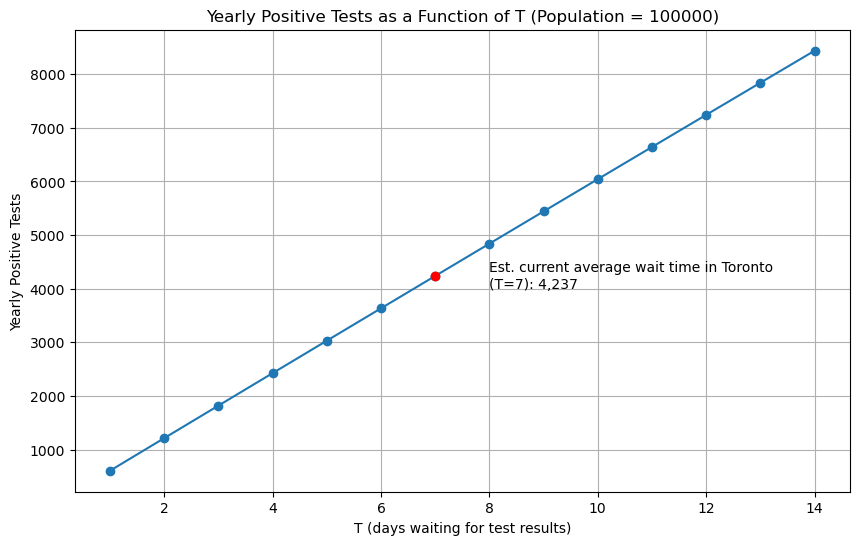

In [21]:

def compute_yearly_positive_cases(solution, daily_tests_A, daily_tests_B, N):
    # Extract the last year's data from the solution
    last_year_data = solution[-365:]
    
    # Compute the number of positive tests each day due to asymptomatic cases
    positive_tests_A = (daily_tests_A * last_year_data[:, 3]) / N  # Asymptomatic positive tests from Group A
    positive_tests_B = (daily_tests_B * last_year_data[:, 3]) / N  # Asymptomatic positive tests from Group B
    
    # Count all symptomatic individuals as positive
    symptomatic_positives = last_year_data[:, 2]  # Symptomatic compartment
    
    # Sum up the positives for both asymptomatic tests and symptomatic cases
    total_positive_cases = np.sum(positive_tests_A + positive_tests_B + symptomatic_positives)
    
    return total_positive_cases

# Simulation & Calculation of yearly positive cases
Ts = list(range(1, 15))
yearly_positive_cases = []

for T in Ts:
    solution = odeint(gonorrhea_model, [X0, E0, S0, A0], t, args=(beta, epsilon, gamma_s, lambda_, T, N))
    yearly_cases = compute_yearly_positive_cases(solution, daily_tests_A, daily_tests_B, N)
    yearly_positive_cases.append(yearly_cases)

# Plot yearly positive cases for varying T values
plt.figure(figsize=(10, 6))
plt.plot(Ts, yearly_positive_cases, marker='o')
plt.xlabel('T (days waiting for test results)')
plt.ylabel('Yearly Positive Tests')
plt.title(f'Yearly Positive Tests as a Function of T (Population = {N})')



# Highlight the point for particular T
T_value_to_highlight = 7
y_value_for_T_highlight = yearly_positive_cases[Ts.index(T_value_to_highlight)]
plt.scatter(T_value_to_highlight, y_value_for_T_highlight, color='red', zorder=5)  # zorder ensures this point is drawn on top


# Annotate the point for T=7
annotation_text = (f"Est. current average wait time in Toronto\n"
                   f"(T={T_value_to_highlight}): {int(y_value_for_T_highlight):,}")
plt.annotate(annotation_text, 
             (T_value_to_highlight, y_value_for_T_highlight), 
             xytext=(T_value_to_highlight+1, y_value_for_T_highlight),  # slight offset to place text next to the point
             horizontalalignment='left',
             verticalalignment='center')


plt.grid(True)
plt.show()


TRY AGAIN


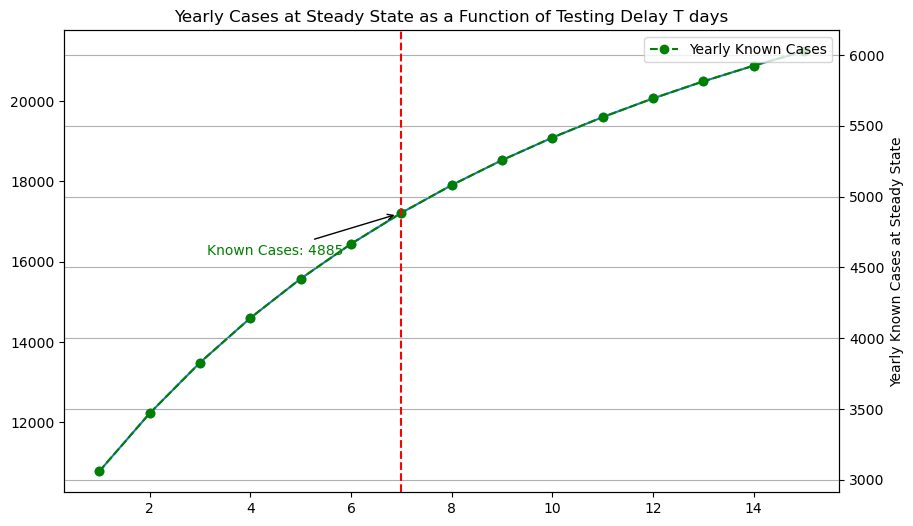

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.8*(2/30)       # Transmission rate, 80% infection prob * (2 partners per month) 
epsilon = 1/5    # Rate of progression from exposed to infectious (inverse of latent period)
gamma_s = 1/7    # Rate of recovery for symptomatic individuals (they immediately get treated)
gamma_a = 0.60 / 14  # Natural recovery rate for asymptomatic individuals
lambda_ = 0.72    # Proportion developing asymptomatic infection
N = 250000       # Total population
p_3months = 0.3  # Proportion tested every 3 months
p_12months = 0.7 # Proportion tested every 12 months

# Initial conditions
E0 = 0.5*N # Initial exposed individuals.
X0 = N - E0  # Initial susceptible individuals.
S0 = 0      # Initial symptomatic individuals.
A0 = 0      # Initial asymptomatic individuals.


#NOTE TO GREG: R_0 = beta (transmission rate)* (duration of infection)*(initial proportion of susceptible=1 if everyone is susceptible)
#Duration of infection is the mean infectious period
#Calculate the R_0 for this group where everyone is getting tested regularly. The mean period of infection is bounded by 1 year 


# Define the model
def gonorrhea_model(Y, t, beta, epsilon, gamma_s, gamma_a, lambda_, T, N):
    X, E, S, A = Y
    dXdt = -beta * X * (S + A) / N + gamma_s * S + (p_3months/91 + p_12months/365)/(T) * A + gamma_a * A
    dEdt = beta * X * (S + A) / N - epsilon * E
    dSdt = (1 - lambda_) * epsilon * E - gamma_s * S
    dAdt = lambda_ * epsilon * E - (p_3months/91 + p_12months/365)/(T) * A - gamma_a * A
    return [dXdt, dEdt, dSdt, dAdt]

# Time array: Simulate over 10 years but use the last year's data for steady state
t = np.linspace(0, 10*365, 10*365)

# Lists to store yearly cases and yearly known cases for each T value at steady state
yearly_cases = []
yearly_known_cases = []

Ts=range(1,16)

for T in Ts:
    solution = odeint(gonorrhea_model, [X0, E0, S0, A0], t, args=(beta, epsilon, gamma_s, gamma_a, lambda_, T, N))
    
    # Only consider the last year's data for steady state
    last_year_data = solution[-365:]
    
    # Calculate the flow into symptomatic and asymptomatic compartments for the last year
    symptomatic_flow = (1 - lambda_) * epsilon * last_year_data[:, 1]
    asymptomatic_flow = lambda_ * epsilon * last_year_data[:, 1]
    
    # Sum the flow over the last year to get steady state yearly cases
    total_cases_for_T = np.sum(symptomatic_flow + asymptomatic_flow)
    yearly_cases.append(total_cases_for_T)
    
    # Corrected calculation for known positive cases for the last year
    known_symptomatic_flow = symptomatic_flow  # Since all symptomatic cases are known
    known_asymptomatic_flow = asymptomatic_flow * (p_3months/91 + p_12months/365)
    
    known_cases_for_T = np.sum(known_symptomatic_flow + known_asymptomatic_flow)
    yearly_known_cases.append(known_cases_for_T)

plt.figure(figsize=(10, 6))

# Plot yearly total cases
plt.plot(Ts, yearly_cases, marker='o', label='Yearly Total Cases')

# Plot yearly known cases using a twin axis
ax2 = plt.gca().twinx()
ax2.plot(Ts, yearly_known_cases, marker='o', color='green', label='Yearly Known Cases', linestyle='--')

# Add vertical line at T=7
plt.axvline(x=7, color='r', linestyle='--')

# Fetch the index and y-values at T=7
index_T7 = Ts.index(7)
y1_at_T7 = yearly_cases[index_T7]
y2_at_T7 = yearly_known_cases[index_T7]

# Annotation for T=7 with y-values for total cases
plt.annotate(f'T=7\nTotal Cases: {y1_at_T7:.0f}', 
             xy=(7, y1_at_T7), 
             xytext=(7+1.5, y1_at_T7 + (max(yearly_cases) - min(yearly_cases)) * 0.1), 
             arrowprops=dict(facecolor='black', arrowstyle='->', shrinkA=5, shrinkB=5), 
             color='blue', 
             ha='center')

# Annotation for T=7 with y-values for known cases
ax2.annotate(f'Known Cases: {y2_at_T7:.0f}', 
             xy=(7, y2_at_T7), 
             xytext=(7-2.5, y2_at_T7 - (max(yearly_known_cases) - min(yearly_known_cases)) * 0.1), 
             arrowprops=dict(facecolor='black', arrowstyle='->', shrinkA=5, shrinkB=5), 
             color='green', 
             ha='center')


# Setting labels, title, and legend
plt.xlabel('T (average days waiting for test results)')
plt.ylabel('Yearly Total Cases at Steady State')
ax2.set_ylabel('Yearly Known Cases at Steady State')
plt.title('Yearly Cases at Steady State as a Function of Testing Delay T days')
plt.grid(True)
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()




In [ ]:
# New list to store yearly known cases for each T value at steady state
yearly_known_cases = []

for T in Ts:
    solution = odeint(gonorrhea_model, [X0, E0, S0, A0], t, args=(beta, epsilon, gamma_s, gamma_a, lambda_, T, N))
    
    # Only consider the last year's data for steady state
    last_year_data = solution[-365:]
    
    # Corrected calculation for known positive cases for the last year
    known_cases_for_T = np.sum(last_year_data[:, 2] + last_year_data[:, 3] * (p_3months/91 + p_12months/365))
    
    yearly_known_cases.append(known_cases_for_T)

# Plot steady-state yearly known cases for varying T values
plt.figure(figsize=(10, 6))
plt.plot(Ts, yearly_known_cases, marker='o', color='green', label='Yearly Known Cases')
plt.xlabel('T (average days waiting for test results)')
plt.ylabel('Yearly Known Cases at Steady State')
plt.title('Yearly Known Cases at Steady State as a Function of Testing Delay T days')
plt.grid(True)
plt.legend()
plt.show()



Stochastic Version


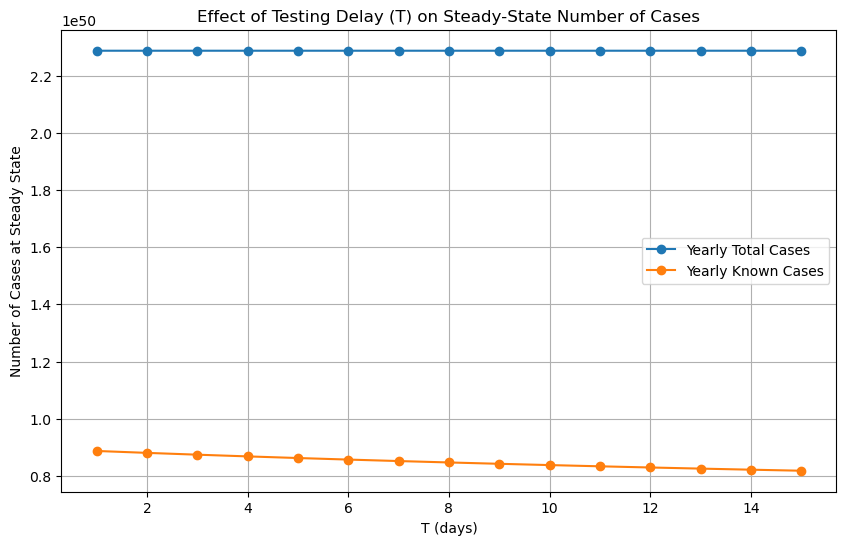

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.8 * (2 / 30)  # Transmission rate
epsilon = 1 / 5  # Rate of progression from exposed to infectious
gamma_s = 1 / 7  # Rate of recovery for symptomatic individuals
gamma_a = 0.60 / 14  # Natural recovery rate for asymptomatic individuals
lambda_ = 0.72  # Proportion developing asymptomatic infection
N = 250000  # Total population
p_3months = 0.3  # Proportion tested every 3 months
p_12months = 0.7  # Proportion tested every 12 months

# Initial conditions
E0 = 0.5 * N  # Initial exposed individuals
X0 = N - E0  # Initial susceptible individuals
S0 = 0  # Initial symptomatic individuals
A0 = 0  # Initial asymptomatic individuals
W0 = 0  # Initial individuals waiting for test results
R0 = 0  # Initial recovered individuals

# Define the model with a 'Waiting for test results' compartment
def gonorrhea_model(Y, t, beta, epsilon, gamma_s, gamma_a, lambda_, T, N, p_3months, p_12months):
    X, E, S, A, W, R = Y
    testing_rate = (p_3months / 91 + p_12months / 365)
    
    dXdt = -beta * X * (S + A) / N + gamma_s * S + gamma_a * A
    dEdt = beta * X * (S + A) / N - epsilon * E
    dSdt = (1 - lambda_) * epsilon * E - gamma_s * S
    dAdt = lambda_ * epsilon * E - testing_rate * A
    dWdt = testing_rate * A - W / T  # People move from W to R after a delay of T days
    dRdt = W / T + gamma_s * S + gamma_a * A  # Recovery due to testing and natural recovery
    
    return [dXdt, dEdt, dSdt, dAdt, dWdt, dRdt]

# Time array: Simulate over 10 years but use the last year's data for steady state
t = np.linspace(0, 10*365, 10*365)

# Lists to store yearly cases and yearly known cases for each T value at steady state
yearly_cases = []
yearly_known_cases = []

# Loop over different values of T
Ts = range(1, 16)

for T in Ts:
    # Simulate the model
    solution = odeint(
        gonorrhea_model, 
        [X0, E0, S0, A0, W0, R0], 
        t, 
        args=(beta, epsilon, gamma_s, gamma_a, lambda_, T, N, p_3months, p_12months)
    )
    
    # Only consider the last year's data for steady state
    last_year_data = solution[-365:]
    
    # Calculate the total cases and known cases at steady state
    total_cases = np.sum((1 - lambda_) * epsilon * last_year_data[:, 1] + lambda_ * epsilon * last_year_data[:, 1])
    known_cases = np.sum((1 - lambda_) * epsilon * last_year_data[:, 1] + last_year_data[:, 4] / T)
    
    yearly_cases.append(total_cases)
    yearly_known_cases.append(known_cases)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Ts, yearly_cases, marker='o', label='Yearly Total Cases')
plt.plot(Ts, yearly_known_cases, marker='o', label='Yearly Known Cases')

plt.xlabel('T (days)')
plt.ylabel('Number of Cases at Steady State')
plt.title('Effect of Testing Delay (T) on Steady-State Number of Cases')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Delay DE

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
beta = 0.8*(3/30)        # Transmission rate, 80% infection prob * (2 partners per month)
epsilon = 1/5            # Rate of progression from exposed to infectious (inverse of latent period)
gamma_s = 1/7            # Rate of recovery for symptomatic individuals (they immediately get treated)
gamma_a = 0.60 / 14      # Natural recovery rate for asymptomatic individuals
lambda_ = 0.72           # Proportion developing asymptomatic infection
N = 250000               # Total population
p_3months = 0.3          # Proportion tested every 3 months
p_12months = 0.7         # Proportion tested every 12 months

# Initial conditions
E0 = 0.5 * N             # Initial exposed individuals.
X0 = N - E0              # Initial susceptible individuals.
S0 = 0                   # Initial symptomatic individuals.
A0 = 0                   # Initial asymptomatic individuals.

# Define the delayed model
def gonorrhea_model_delay(Y, t, beta, epsilon, gamma_s, gamma_a, lambda_, p_3months, p_12months, tau, N):
    # Since we cannot directly use the delayed A value in the ODEs, we need to find a workaround
    # Using the history of A to find the delayed value
    A_delayed = np.interp(t - tau, t_points, A_history)
    
    X, E, S, A = Y
    
    testing_rate = (p_3months/91 + p_12months/365)
    
    dXdt = -beta * X * (S + A) / N + gamma_s * S + gamma_a * A_delayed
    dEdt = beta * X * (S + A) / N - epsilon * E
    dSdt = (1 - lambda_) * epsilon * E - gamma_s * S
    dAdt = lambda_ * epsilon * E - testing_rate * A_delayed - gamma_a * A
    
    return [dXdt, dEdt, dSdt, dAdt]

# Time array: Simulate over 10 years
t_points = np.linspace(0, 10 * 365, 10 * 365)
tau = 10  # Delay in days for getting test results

# We need to keep a history of the A compartment to look up delayed values
A_history = np.zeros(t_points.shape)
A_history[0] = A0

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-6

# Loop over each day and solve the ODEs
solution = np.zeros((len(t_points), 4))
solution[0] = [X0, E0, S0, A0]

for i in range(1, len(t_points)):
    tspan = [t_points[i-1], t_points[i]]
    ys = odeint(gonorrhea_model_delay, solution[i-1], tspan, args=(beta, epsilon, gamma_s, gamma_a, lambda_, p_3months, p_12months, tau, N), atol=abserr, rtol=relerr)
    
    # Update the solution
    solution[i] = ys[-1]
    
    # Update A's history
    A_history[i] = ys[-1][3]

# Extract the last year's data for steady state
last_year_data = solution[-365:]

# Total cases are just the sum of new symptomatic and asymptomatic cases
yearly_cases = (1 - lambda_) * epsilon * np.sum(last_year_data[:, 1]) + lambda_ * epsilon * np.sum(last_year_data[:, 1])

# Total known cases are those symptomatic and those asymptomatic that are tested
yearly_known_cases = np.sum(last_year_data[:, 2]) + (p_3months / 91 + p_12months / 365) * np.sum(last_year_data[:, 3])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t_points, solution[:, 2], label='Symptomatic individuals')
plt.plot(t_points, solution[:, 3], label='Asymptomatic individuals')
plt.xlabel('Days')
plt.ylabel('Number of Individuals')
plt.title('Dynamics of Gonorrhea Infection with Testing Delay')
plt.legend()
plt.grid(True)
plt.show()

print(f"Yearly cases at steady state: {yearly_cases}")
print(f"Yearly known cases at steady state: {yearly_known_cases}")
